### Cargo los datos

In [53]:
from dotenv import load_dotenv
import psycopg2
import os
import pandas as pd

load_dotenv()

DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')

conn = psycopg2.connect(host=DB_HOST, database=DB_NAME, user=DB_USER, password=DB_PASSWORD)

df = pd.read_sql_query("select * from reservas where es_simulado = True", conn)

C:\Users\Matko\AppData\Local\Temp\ipykernel_15440\1655766237.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("select * from reservas where es_simulado = True", conn)


In [54]:
df.head()

,id_reserva,id_instalacion,ds_nombre_cliente,dt_fechahora_inicio,dt_fechahora_fin,dt_fechahora_creacion,ds_estado,ds_comentarios,ds_telefono,es_simulado,lluvia,probabilidad_cancelacion,antelacion_dias,reservas_previas,cancelaciones_previas,es_finde,es_horario_pico,es_feriado
0,10000,12,Melchor Royo Acero,2025-01-21 10:00:00+00:00,2025-01-21 11:00:00+00:00,2025-01-20 10:00:00+00:00,Confirmada,,34629259677,True,True,0.42,1,3,0,0,0,0
1,10001,3,Edelmira Collado,2025-05-04 14:00:00+00:00,2025-05-04 15:00:00+00:00,2025-05-04 14:00:00+00:00,Cancelada,,34617107524,True,True,0.51,0,3,2,1,0,0
2,10002,9,Carmelita Martí-Rovira,2025-05-28 20:00:00+00:00,2025-05-28 21:00:00+00:00,2025-05-23 20:00:00+00:00,Confirmada,,34641411266,True,False,0.19,5,1,0,0,1,0
3,10003,1,Ciro Cámara Vallés,2025-05-12 19:00:00+00:00,2025-05-12 20:00:00+00:00,2025-05-11 19:00:00+00:00,Cancelada,,34670298008,True,False,0.18,1,2,0,0,1,0
4,10004,4,Anastasio Barrio Vilanova,2025-06-13 09:00:00+00:00,2025-06-13 10:00:00+00:00,2025-06-13 09:00:00+00:00,Confirmada,,34623369281,True,False,0.09,0,1,0,0,0,0


### Limpieza y Corrección del tipo de datos

In [55]:
# Descarto la columna ds_comentarios 
df = df.drop(columns=['ds_comentarios', 'ds_nombre_cliente'])

In [56]:
df.dtypes

id_reserva                                int64
id_instalacion                            int64
dt_fechahora_inicio         datetime64[ns, UTC]
dt_fechahora_fin            datetime64[ns, UTC]
dt_fechahora_creacion       datetime64[ns, UTC]
ds_estado                                object
ds_telefono                              object
es_simulado                                bool
lluvia                                     bool
probabilidad_cancelacion                float64
antelacion_dias                           int64
reservas_previas                          int64
cancelaciones_previas                     int64
es_finde                                  int64
es_horario_pico                           int64
es_feriado                                int64
dtype: object

In [57]:
# Reviso duplicados
print(f'Existen {df.duplicated().sum()} registros duplicados. \n')

# Analizo los valores nulos para el df
print(df.isnull().sum())

Existen 0 registros duplicados. 

id_reserva                  0
id_instalacion              0
dt_fechahora_inicio         0
dt_fechahora_fin            0
dt_fechahora_creacion       0
ds_estado                   0
ds_telefono                 0
es_simulado                 0
lluvia                      0
probabilidad_cancelacion    0
antelacion_dias             0
reservas_previas            0
cancelaciones_previas       0
es_finde                    0
es_horario_pico             0
es_feriado                  0
dtype: int64


Tranformo datos

In [58]:
# 1. Eliminar columnas que no aportan valor predictivo
columnas_a_eliminar = [
    'id_reserva',
    'dt_fechahora_inicio',
    'dt_fechahora_fin',
    'dt_fechahora_creacion',
    'ds_telefono',
    'es_simulado',
    'probabilidad_cancelacion'
]
df = df.drop(columns=columnas_a_eliminar)

# 2. Crear variable objetivo binaria (1 = Cancelada, 0 = Confirmada)
df['cancelada'] = (df['ds_estado'] == 'Cancelada').astype(int)

# 3. Eliminar la columna original de estado (ya no se necesita)
df = df.drop(columns=['ds_estado'])

# 4. Convertir id_instalacion a tipo categórico (opcional pero recomendado para modelos)
df['id_instalacion'] = df['id_instalacion'].astype('category')

# 5. Convierto lluvia a int 
df['lluvia'] = df['lluvia'].astype(int)


In [59]:
df.dtypes

id_instalacion           category
lluvia                      int64
antelacion_dias             int64
reservas_previas            int64
cancelaciones_previas       int64
es_finde                    int64
es_horario_pico             int64
es_feriado                  int64
cancelada                   int64
dtype: object

In [60]:
df.head()

,id_instalacion,lluvia,antelacion_dias,reservas_previas,cancelaciones_previas,es_finde,es_horario_pico,es_feriado,cancelada
0,12,1,1,3,0,0,0,0,0
1,3,1,0,3,2,1,0,0,1
2,9,0,5,1,0,0,1,0,0
3,1,0,1,2,0,0,1,0,1
4,4,0,0,1,0,0,0,0,0


In [61]:
df['cancelada'].value_counts()

cancelada
0    10865
1     4135
Name: count, dtype: int64

### Entrenamos el modelo

Seleccionamos features (X) y target (y)

In [62]:
# Target
y = df['cancelada']

# Features
X = df[[
    'id_instalacion',
    'lluvia',
    'antelacion_dias',
    'reservas_previas',
    'cancelaciones_previas',
    'es_finde',
    'es_horario_pico',
    'es_feriado'
]]

Dividimos en train/test

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y # la proporción de clases en la variable objetivo (y) se mantiene igual en los conjuntos de entrenamiento y prueba
)


Entrenamos el Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=42)

Evaluamos el rendimiento    

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilidad de cancelación

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

[[2375  341]
 [ 644  390]]
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      2716
           1       0.53      0.38      0.44      1034

    accuracy                           0.74      3750
   macro avg       0.66      0.63      0.64      3750
weighted avg       0.72      0.74      0.72      3750

ROC AUC: 0.7245415803761932


Importancia de variables

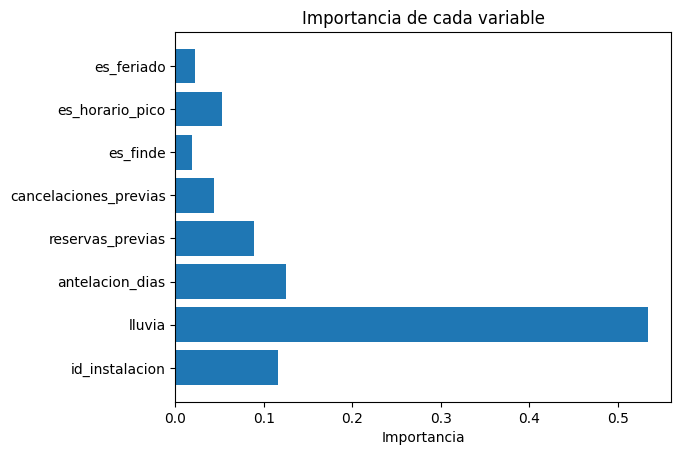

In [66]:
import matplotlib.pyplot as plt

importancias = clf.feature_importances_
features = X.columns

plt.barh(features, importancias)
plt.xlabel("Importancia")
plt.title("Importancia de cada variable")
plt.show()


## Grid Search + CV

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split

# Dividir datos en train/test (opcional, para evaluación final)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instanciar modelo base
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Definir grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Definir scoring personalizado (por ejemplo F1 para clase positiva)
f1_scorer = make_scorer(f1_score, pos_label=1)

# Configurar Grid Search con 5 folds
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Ejecutar búsqueda
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor F1 score en CV:", grid_search.best_score_)

# Evaluar en test con el mejor modelo
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC AUC en test:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor F1 score en CV: 0.5516545423732649
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2716
           1       0.51      0.60      0.55      1034

    accuracy                           0.73      3750
   macro avg       0.67      0.69      0.68      3750
weighted avg       0.75      0.73      0.74      3750

ROC AUC en test: 0.7349345379340992


Lo guardo en pickle

In [71]:
import pickle

with open('rf_cancelaciones.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

In [72]:
# Guardar columnas en un archivo aparte (json, txt, pickle)
import json
with open('columnas_modelo.json', 'w') as f:
    json.dump(X_train.columns.tolist(), f)


Pruebo hacer una predicción cualquiera

In [74]:
import pickle
import pandas as pd
import json

# Cargar el modelo desde el archivo .pkl
with open('rf_cancelaciones.pkl', 'rb') as f:
    modelo = pickle.load(f)

# Cargar la lista de columnas en el orden correcto desde JSON
with open('columnas_modelo.json', 'r') as f:
    columnas = json.load(f)

# Valores para la predicción, en formato dict con las columnas que usás
valores = {
    'id_instalacion': 3,
    'antelacion_dias': 5,
    'reservas_previas': 1,
    'cancelaciones_previas': 0,
    'es_finde': 0,
    'es_horario_pico': 1,
    'es_feriado': 0,
    'lluvia': 1
}

# Crear un DataFrame vacío con las columnas en el orden correcto
X_nuevo = pd.DataFrame(columns=columnas)

# Insertar los valores en la fila 0 respetando el orden de columnas
# Si alguna columna no está en valores, asigna 0 o NaN según convenga
fila = []
for col in columnas:
    fila.append(valores.get(col, 0))  # aquí podés cambiar el 0 por np.nan si querés

X_nuevo.loc[0] = fila

# Predecir con el modelo cargado
prediccion = modelo.predict(X_nuevo)
probabilidades = modelo.predict_proba(X_nuevo)

print(f"Predicción (0=confirmada, 1=cancelada): {prediccion}")
print(f"Probabilidades de clase: {probabilidades}")



Predicción (0=confirmada, 1=cancelada): [1]
Probabilidades de clase: [[0.28723365 0.71276635]]
